<a href="https://colab.research.google.com/github/KAVYANSHTYAGI/Ransomware-Analysis-using-Machine-Learning-and-Deep-Learning/blob/main/CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.preprocessing.image import load_img,img_to_array

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


method 2

In [3]:
import pandas as pd
import numpy as np
from PIL import Image

# Function to convert CSV to image array directly in memory
def csv_to_image_array(data, dtype=None, img_dim=(224,224), img_type='RGB'):
    images = []
    no_of_features = data.shape[1]
    sqrt_of_no_of_features = int(np.sqrt(no_of_features))
    if np.sqrt(no_of_features) > sqrt_of_no_of_features:
        sqrt_of_no_of_features += 1

    for index, row in data.iterrows():
        pixels = np.resize(row.values, (sqrt_of_no_of_features**2)).reshape(sqrt_of_no_of_features, sqrt_of_no_of_features)
        image = Image.fromarray(pixels.astype(np.uint8))
        if img_type != 'Gray':
            image = image.convert(img_type)
        image = image.resize(img_dim, Image.Resampling.NEAREST)
        images.append(np.array(image))
    return np.array(images)

# Load your dataset
data_path = '/content/drive/MyDrive/ransomware_analysis_files/gan_for_synthetic/balanced_oversampled_very_noisy_extended_5k.csv'
dataset = pd.read_csv(data_path)

# Check for NaN values in the target variable and remove them if found
if dataset['Tag_y'].isnull().any():
    print("NaN values found in target variable 'Tag_y', removing rows...")
    dataset = dataset.dropna(subset=['Tag_y'])

# Dropping unnecessary columns
features_to_drop = ['Tag_y', 'Tag_x', 'filename', 'cryptographic_usage_encryption_algorithms',
                    'complexity_metrics_function_count', 'data_flow_collections_usage', 'hardcoded_urls',
                    'obfuscation_techniques_variable_name_length', 'unique_suspicious_strings']
X_data = dataset.drop(columns=features_to_drop)
y_train = dataset['Tag_y'].values  # Assuming y_train corresponds to the rows in the CSV

# Convert the filtered CSV data into images
X_train = csv_to_image_array(X_data, dtype='uint8', img_dim=(224,224), img_type='RGB')

# Optionally, verify the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


<ipython-input-3-ea390ae9c461>:15: RuntimeWarning: invalid value encountered in cast
  image = Image.fromarray(pixels.astype(np.uint8))


X_train shape: (12012, 224, 224, 3)
y_train shape: (12012,)


In [4]:
def pseudo_color_image(data, dtype=np.uint8, img_dim=(224, 224), default_value=0):
    images = []
    color_map = {
        0: (0, 0, 0),  # Black for background
        1: (255, 0, 0),  # Red
        2: (0, 255, 0),  # Green
        3: (0, 0, 255),  # Blue
        # Define more as needed
    }

    data = data.fillna(default_value)  # Fill NaN values with a default value

    for index, row in data.iterrows():
        # Process each pixel
        colored_image = np.zeros((row.size * 3,), dtype=dtype)
        for i, value in enumerate(row):
            colored_image[i*3:i*3+3] = color_map.get(int(value), (255, 255, 255))

        # Calculate the dimension needed for a square image
        dim = int(np.ceil(np.sqrt(len(colored_image) / 3)))
        full_size = dim * dim * 3
        colored_image = np.pad(colored_image, (0, full_size - len(colored_image)), 'constant', constant_values=0)

        # Reshape and resize
        image = Image.fromarray(colored_image.reshape((dim, dim, 3)))
        image = image.resize(img_dim, Image.Resampling.NEAREST)
        images.append(np.array(image))

    return np.array(images)

# Convert the filtered CSV data into pseudo-colored images
X_train = pseudo_color_image(X_data)


Enter the number of images you want to display for label 0: 8
Enter the number of images you want to display for label 1: 8


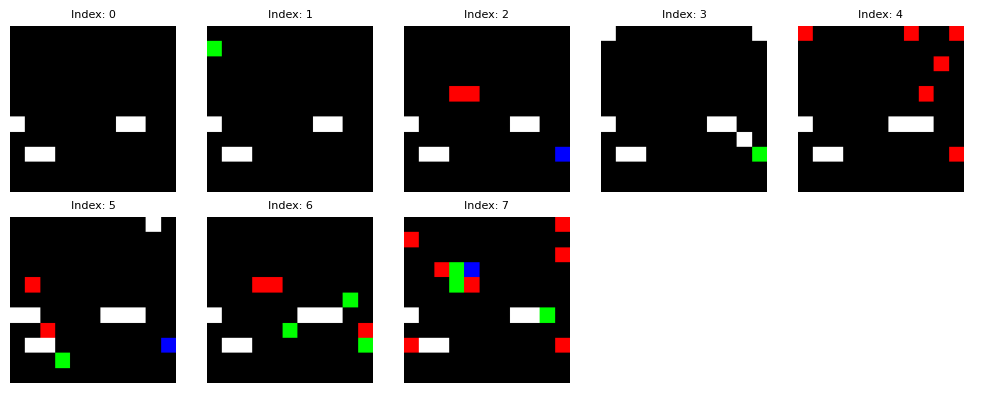

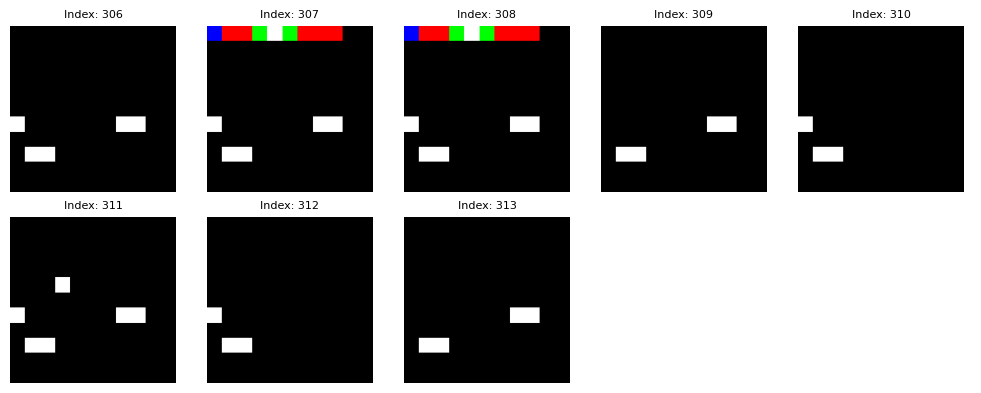

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_images_by_label(X_train, y_train):
    unique_labels = np.unique(y_train)

    for label in unique_labels:
        indices = np.where(y_train == label)[0]

        # User inputs the number of images they want to see for this label
        num_images = int(input(f"Enter the number of images you want to display for label {label}: "))

        if num_images > len(indices):
            print(f"Only {len(indices)} images available, showing all.")
            num_images = len(indices)

        selected_indices = indices[:num_images]

        # Determine the number of columns for subplot
        cols = min(num_images, 5)  # Show a maximum of 5 images per row
        rows = (num_images + cols - 1) // cols  # Calculate the needed rows

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

        if rows * cols > 1:
            axes = axes.ravel()
        else:
            axes = [axes]

        for ax, idx in zip(axes, selected_indices):
            ax.imshow(X_train[idx])
            ax.set_title(f'Index: {idx}', fontsize=8)
            ax.axis('off')

        for ax in axes[len(selected_indices):]:
            ax.axis('off')  # Hide unused subplots

        plt.tight_layout()
        plt.show()

# Example usage
# X_train = np.random.rand(100, 64, 64, 3)  # Example array of 100 64x64 RGB images
# y_train = np.random.randint(0, 2, 100)    # Example array of 100 labels (0 or 1)
show_images_by_label(X_train, y_train)


In [ ]:
X_train = None
X_test = None


In [ ]:
y_train = None
y_test = None

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def split_data(X, y, train_size, val_size, test_size):
    # Keep data handling on the CPU
    with tf.device('/cpu:0'):
        # Convert TensorFlow tensors to numpy arrays if they are not already
        if isinstance(X, tf.Tensor):
            X = X.numpy()
        if isinstance(y, tf.Tensor):
            y = y.numpy()

        # First split to separate out the training set
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=42)

        # Calculate the proportion of the remaining data to allocate to validation
        prop_remain = val_size / (val_size + test_size)

        # Second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=prop_remain, random_state=42)

        # Optionally convert arrays back to tensors here, if you plan on using them directly after this
        # However, you can defer this conversion until you are about to use them in a model to save memory
        return X_train, X_val, X_test, y_train, y_val, y_test

# Assuming X_train_resized and y_train_categorical are ready and correctly formatted as tensors
# This function now returns numpy arrays instead of tensors to prevent memory allocation on GPU
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_train, y_train, 0.8, 0.1, 0.1)

# Print the shapes of the datasets to verify the splits
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: (9609, 224, 224, 3)
X_val shape: (1201, 224, 224, 3)
X_test shape: (1202, 224, 224, 3)
y_train shape: (9609,)
y_val shape: (1201,)
y_test shape: (1202,)


In [6]:
num_classes = 2
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9609, 224, 224, 3)
X_val shape: (1201, 224, 224, 3)
X_test shape: (1202, 224, 224, 3)
y_train shape: (9609, 2)
y_val shape: (1201, 2)
y_test shape: (1202, 2)


In [ ]:
import tensorflow as tf

# Assuming y_train, y_val, and y_test are loaded as one-hot encoded arrays
# Example conversion of a one-hot encoded label tensor to sparse labels
y_train = tf.argmax(y_train, axis=1)
y_val = tf.argmax(y_val, axis=1)
y_test = tf.argmax(y_test, axis=1)


In [7]:
# Data Augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=70,        # Random rotation between -10 to +10 degrees
    width_shift_range=0.1,    # Horizontal shift
    height_shift_range=0.1,   # Vertical shift
    zoom_range=0.1,           # Random zoom
    horizontal_flip=True,     # Horizontal flip
    fill_mode='nearest'  ,
    featurewise_center=True,
    featurewise_std_normalization=True
)

train_generator = datagen.flow(X_train, y_train)

Custom layers

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(next_square, next_square, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_categorical.shape[1], activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
model.fit(datagen.flow(X_train_resized, y_train, batch_size=64),
          epochs=30,
          validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

CUSTOM MODEL INSPIRED BY INCEPTIONV3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

model = Sequential()

# Input shape is the size of the images you are inputting
input_shape = (224,224,3)

# Stem block
model.add(Conv2D(32, (3,3), strides=(2,2), padding='valid', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3,3), padding='valid', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((3,3), strides=(2,2)))

model.add(Conv2D(80, (1,1), padding='valid', activation='relu'))
model.add(Conv2D(192, (3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D((3,3), strides=(2,2)))

# Assuming adding one inception block (as a linear approximation)
# Inception blocks here are simplified and not parallel
model.add(Conv2D(64, (1,1), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D((3,3), strides=(2,2), padding='same'))

# It's not possible to implement cross-channel parameterized pooling (like in Inception modules) in a Sequential model directly

# Final classifier
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))  # Output layer size should match the number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_hybrid_model.keras', monitor='val_loss', save_best_only=True)




Single Pre-trained models

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

num_classes = 2

# Using MobileNetV2 as the base model with pre-trained ImageNet weights
base_model = InceptionResNetV2(include_top=False,
                         weights='imagenet',
                         input_shape=(224, 224, 3))

# Setting the base model as non-trainable
base_model.trainable = True

# Building the complete model
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

# Configuring the optimizer
optimizer = Adam(learning_rate=1e-4)

# Compiling the model with necessary parameters
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # This is important for classification
              metrics=['accuracy'])

# Setting up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# The model is now ready to be trained with model.fit(), ensuring to provide validation data and using the callbacks


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Hybrid Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, MobileNetV3Small
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


num_classes = 2

# Input shape
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Load ResNet50 and VGG19 pre-trained models
resnet_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)

# Set base models as trainable (or freeze as required)
resnet_base.trainable = True
vgg_base.trainable = True

# Extract features
resnet_features = GlobalAveragePooling2D()(resnet_base(inputs))
vgg_features = GlobalAveragePooling2D()(vgg_base(inputs))

# Concatenate features
combined_features = Concatenate()([resnet_features, vgg_features])

# Add a classification head
x = Dense(512, activation='relu')(combined_features)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='sigmoid')(x)

# Build the model
hybrid_model = Model(inputs, outputs)

# Configure the optimizer
optimizer = Adam(learning_rate=1e-4)

hybrid_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Change to 'categorical_crossentropy' if using categorical targets
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        F1Score()
    ]
)

# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_hybrid_model.keras', monitor='val_loss', save_best_only=True)

# Model summary
hybrid_model.summary()


CNN + RNN HYBRID

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

# Simple Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

def build_cnn_rnn_model(input_shape, num_classes):
    # Input layer
    input_layer = Input(shape=input_shape)

    # ResNet50 as the feature extractor
    base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_cnn.trainable = False  # Start with non-trainable layers

    # Wrap the base CNN with TimeDistributed
    cnn_output = TimeDistributed(base_cnn)(input_layer)
    cnn_output = TimeDistributed(Flatten())(cnn_output)

    # Bidirectional LSTM
    lstm_output = Bidirectional(LSTM(256, return_sequences=True))(cnn_output)
    lstm_output = Dropout(0.4)(lstm_output)  # Regularization with Dropout

    # Attention mechanism
    attention_output = Attention()(lstm_output)

    # Final dense layer for classification
    output_layer = Dense(num_classes, activation='softmax')(attention_output)

    # Create and compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = build_cnn_rnn_model(input_shape=(10, 224, 224, 3), num_classes=2)
print(model.summary())



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10, 224, 224, 3   0         
                             )]                                  
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 7, 7, 2048)    23587712  
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 100352)        0         
 stributed)                                                      
                                                                 
 bidirectional_1 (Bidirecti  (None, 10, 512)           206047232 
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 10, 512)           0   

In [17]:
import numpy as np

# Example: Setting sequence length
sequence_length = 10

# Reshape X_train assuming the number of images is divisible by sequence_length
num_sequences = X_train.shape[0] // sequence_length
new_shape = (num_sequences, sequence_length) + X_train.shape[1:]
X_train_seq = X_train[:num_sequences * sequence_length].reshape(new_shape)

# Adjust labels similarly if necessary (assuming y_train is already in the correct shape)
y_train_seq = y_train[:num_sequences * sequence_length].reshape((num_sequences, sequence_length, -1))
y_train_seq = y_train_seq[:, 0, :]  # Assuming label of the first frame represents the label for the whole sequence

print("New X_train shape:", X_train_seq.shape)
print("New y_train shape:", y_train_seq.shape)


New X_train shape: (960, 10, 224, 224, 3)
New y_train shape: (960, 2)


In [ ]:
tf.config.run_functions_eagerly(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_hybrid_model.keras', monitor='val_loss', save_best_only=True)

model.fit(
    x=X_train_seq,
    y=y_train_seq,
    epochs=20,
    validation_split=0.1,  # For example, 10% of the data used as validation set
    callbacks=[model_checkpoint]
)


for layer in model.layers[:40]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = True


model.fit(
    x=X_train_seq,
    y=y_train_seq,
    epochs=50,
    validation_split=0.1,  # For example, 10% of the data used as validation set
    callbacks=[model_checkpoint]
)


Epoch 1/20
27/27 [==============================] - 1143s 42s/step - loss: 2.4506 - accuracy: 0.5046 - val_loss: 0.9996 - val_accuracy: 0.4792
Epoch 2/20
27/27 [==============================] - 1170s 43s/step - loss: 0.8369 - accuracy: 0.5046 - val_loss: 0.7898 - val_accuracy: 0.4792
Epoch 3/20
27/27 [==============================] - 1159s 43s/step - loss: 0.7168 - accuracy: 0.5116 - val_loss: 0.6925 - val_accuracy: 0.4792
Epoch 4/20
16/27 [================>.............] - ETA: 7:32 - loss: 0.6830 - accuracy: 0.5605

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
301/301 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8098 - precision: 0.8062 - recall: 0.8091 - f1_score: 0.8077

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


301/301 [==============================] - 416s 1s/step - loss: 0.4143 - accuracy: 0.8098 - precision: 0.8062 - recall: 0.8091 - f1_score: 0.8077 - val_loss: 0.3672 - val_accuracy: 0.8560 - val_precision: 0.8561 - val_recall: 0.8568 - val_f1_score: 0.8564 - lr: 1.0000e-04
Epoch 2/100
301/301 [==============================] - 372s 1s/step - loss: 0.2981 - accuracy: 0.8793 - precision: 0.8784 - recall: 0.8804 - f1_score: 0.8794 - val_loss: 0.5855 - val_accuracy: 0.6803 - val_precision: 0.6797 - val_recall: 0.6803 - val_f1_score: 0.6800 - lr: 1.0000e-04
Epoch 3/100
301/301 [==============================] - 375s 1s/step - loss: 0.2555 - accuracy: 0.9002 - precision: 0.8995 - recall: 0.9011 - f1_score: 0.9003 - val_loss: 0.3249 - val_accuracy: 0.8676 - val_precision: 0.8675 - val_recall: 0.8668 - val_f1_score: 0.8671 - lr: 1.0000e-04
Epoch 4/100
301/301 [==============================] - 372s 1s/step - loss: 0.2301 - accuracy: 0.9136 - precision: 0.9139 - recall: 0.9135 - f1_score: 0.9137

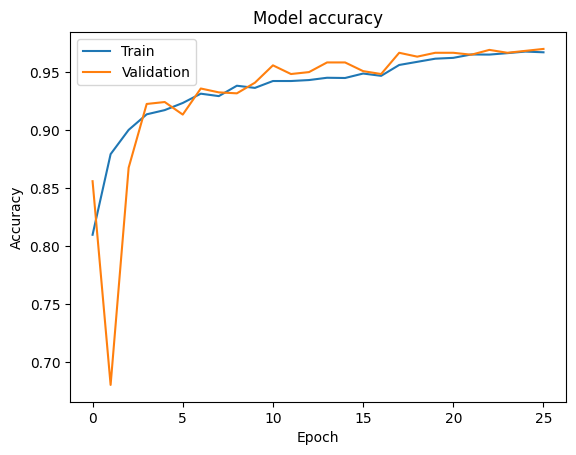

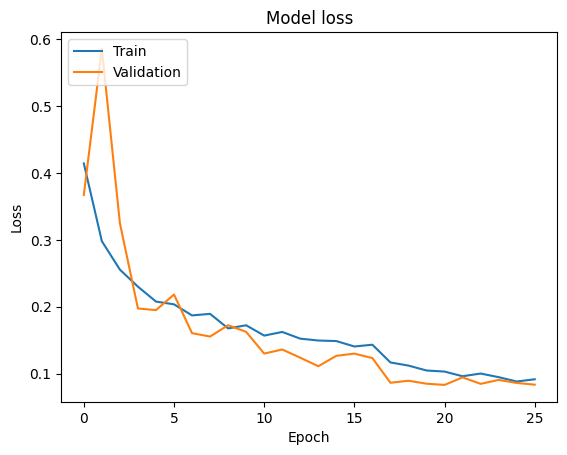

NameError: name 'model' is not defined

In [10]:
history = hybrid_model.fit(
    train_generator,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    shuffle=True)

# Plotting training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


loss, accuracy = model.evaluate(X_val, y_val)
print(f'val Loss: {loss}, val Accuracy: {accuracy}')

loss, accuracy = model.evaluate(X_test, y_test)
print(f'test Loss: {loss}, test Accuracy: {accuracy}')





In [12]:
loss, accuracy, precision, recall, f1_score = hybrid_model.evaluate(X_val, y_val)
print(f'val Loss: {loss}, val Accuracy: {accuracy}')

loss, accuracy, precision, recall, f1_score = hybrid_model.evaluate(X_test, y_test)
print(f'test Loss: {loss}, test Accuracy: {accuracy}')

38/38 [==============================] - 7s 191ms/step - loss: 0.0832 - accuracy: 0.9667 - precision: 0.9659 - recall: 0.9675 - f1_score: 0.9667
val Loss: 0.08317133784294128, val Accuracy: 0.9666944146156311
38/38 [==============================] - 7s 179ms/step - loss: 0.0977 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - f1_score: 0.9667
test Loss: 0.09772341698408127, test Accuracy: 0.9667221307754517


38/38 [==============================] - 7s 187ms/step
Validation Confusion Matrix:
 [[562  25]
 [ 15 599]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       587
           1       0.96      0.98      0.97       614

    accuracy                           0.97      1201
   macro avg       0.97      0.97      0.97      1201
weighted avg       0.97      0.97      0.97      1201

Test Confusion Matrix:
 [[594  21]
 [ 19 568]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       615
           1       0.96      0.97      0.97       587

    accuracy                           0.97      1202
   macro avg       0.97      0.97      0.97      1202
weighted avg       0.97      0.97      0.97      1202



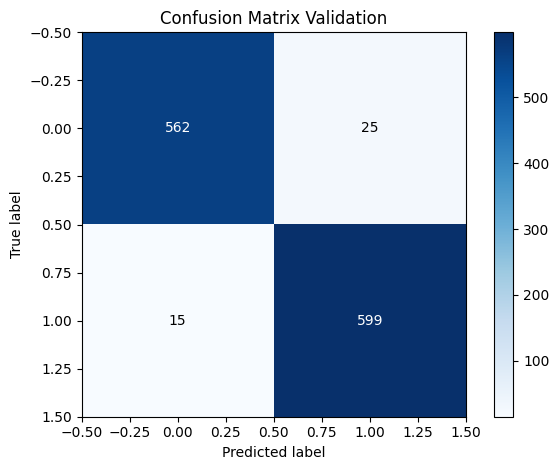

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have trained your model and have the validation and test datasets ready
# Convert validation and test sets to tensors if not already done
X_val, y_val = map(tf.convert_to_tensor, (X_val, y_val))
X_test, y_test = map(tf.convert_to_tensor, (X_test, y_test))

# Predictions
y_val_pred = hybrid_model.predict(X_val)
y_test_pred = hybrid_model.predict(X_test)

# Convert predictions to class labels
y_val_pred = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val.numpy(), axis=1)

y_test_pred = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test.numpy(), axis=1)

# Confusion Matrix
cm_val = confusion_matrix(y_val_true, y_val_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

# Classification Report
cr_val = classification_report(y_val_true, y_val_pred)
cr_test = classification_report(y_test_true, y_test_pred)

print("Validation Confusion Matrix:\n", cm_val)
print("Validation Classification Report:\n", cr_val)
print("Test Confusion Matrix:\n", cm_test)
print("Test Classification Report:\n", cr_test)

# Plot confusion matrix (optional)
fig, ax = plt.subplots()
img = ax.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(img, ax=ax)
ax.set(title='Confusion Matrix Validation',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations.
thresh = cm_val.max() / 2.
for i in range(cm_val.shape[0]):
    for j in range(cm_val.shape[1]):
        ax.text(j, i, format(cm_val[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_val[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


In [ ]:
tf.keras.backend.clear_session()

vision transformer


In [ ]:
# Assuming the input images are already resized to 224x224 and normalized as needed
input_shape = (224, 224, 3)  # Input shape expected by the ViT model


# Convert NumPy arrays to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch size
batch_size = 128

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Check the shapes of the batches in the training dataset
for X_batch, y_batch in train_dataset.take(1):  # Take a single batch
    print("Train dataset - X_batch shape:", X_batch.shape)
    print("Train dataset - y_batch shape:", y_batch.shape)

# Check the shapes of the batches in the validation dataset
#for X_batch, y_batch in val_dataset.take(1):  # Take a single batch
#    print("Validation dataset - X_batch shape:", X_batch.shape)
#    print("Validation dataset - y_batch shape:", y_batch.shape)

# Check the shapes of the batches in the test dataset
for X_batch, y_batch in test_dataset.take(1):  # Take a single batch
    print("Test dataset - X_batch shape:", X_batch.shape)
    print("Test dataset - y_batch shape:", y_batch.shape)

Train dataset - X_batch shape: (128, 224, 224, 3)
Train dataset - y_batch shape: (128, 2)
Test dataset - X_batch shape: (128, 224, 224, 3)
Test dataset - y_batch shape: (128, 2)


In [ ]:
!pip install tensorflow_hub
import tensorflow_hub as hub

In [ ]:
# Load the pre-trained ViT model
# Using the ViT model with 16x16 patches, pre-trained on ImageNet-21k and fine-tuned on ImageNet-1k
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"
vit_layer = hub.KerasLayer(vit_url, trainable=True)

In [ ]:
num_classes = 2
# Updated model function to correctly pass input tensors
def build_finetune_vit_model(x, num_classes):
    # Define the input layer with the correct shape and dtype
    inputs = layers.Input(shape=x , dtype=tf.float32)

    vit_layer = hub.KerasLayer(vit_url, trainable=True)

    # Pass through the pre-trained Vision Transformer layer from TensorFlow Hub
    vit_features = layers.Lambda(lambda x: vit_layer(x))(inputs)

    # Add additional layers for classification
    x = layers.Dense(512, activation='relu')(vit_features)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (224,224,3)
# Build and compile the model

finetune_vit_model = build_finetune_vit_model(input_shape, num_classes)


finetune_vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Print model summary

In [ ]:
finetune_vit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


# Fine-tune the model using the TensorFlow datasets
history = finetune_vit_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=80,  # Fine-tune for a few more epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)
# Evaluate on test data
test_loss, test_acc = finetune_vit_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

Epoch 1/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 73s 604ms/step - accuracy: 0.6247 - loss: 0.7773 - val_accuracy: 0.8451 - val_loss: 0.3738 - learning_rate: 1.0000e-04
Epoch 2/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8053 - loss: 0.4347 - val_accuracy: 0.8643 - val_loss: 0.3348 - learning_rate: 1.0000e-04
Epoch 3/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8421 - loss: 0.3724 - val_accuracy: 0.8609 - val_loss: 0.3238 - learning_rate: 1.0000e-04
Epoch 4/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8566 - loss: 0.3327 - val_accuracy: 0.8851 - val_loss: 0.2784 - learning_rate: 1.0000e-04
Epoch 5/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8737 - loss: 0.3054 - val_accuracy: 0.8901 - val_loss: 0.2636 - learning_rate: 1.0000e-04
Epoch 6/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8851 - loss: 0.2823 - val_accuracy: 0.9026 - val_loss: 0.2474 - learning_rate: 1.0000e-04
Epoch 7/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy:

hybrid model including vision transformer

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

# Pre-trained ViT Model URL
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"
# EfficientNetB5
efficientnet_base = MobileNetV3Small(include_top=False, input_shape=input_shape, weights="imagenet")
efficientnet_base.trainable = False  # Freezing EfficientNetB5 layers

    # ResNet101
resnet_base = InceptionV3(include_top=False, input_shape=input_shape, weights="imagenet")
resnet_base.trainable = False  # Freezing ResNet101 layers

# Build the Hybrid Model
def build_heavy_hybrid_model(input_shape, num_classes):


    # ViT (Vision Transformer)
    vit_layer = hub.KerasLayer(vit_url, trainable=False, input_shape=input_shape)

    # Input Layer
    inputs = layers.Input(shape=input_shape)

    # Extract Features from EfficientNet and ResNet
    efficientnet_features = efficientnet_base(inputs)
    efficientnet_features = layers.GlobalAveragePooling2D()(efficientnet_features)

    resnet_features = resnet_base(inputs)
    resnet_features = layers.GlobalAveragePooling2D()(resnet_features)

    # Concatenate EfficientNet and ResNet features
    combined_features = layers.Concatenate()([efficientnet_features, resnet_features])

    # Feed concatenated features into Vision Transformer
    vit_features = layers.Lambda(lambda x: vit_layer(x))(inputs)


    # Combine ViT features with EfficientNet + ResNet features
    combined_features = layers.Concatenate()([combined_features, vit_features])

    # Fully Connected Layers (deeper head for richer representations)
    x = layers.Dense(512, activation='relu')(combined_features)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    # Output Layer (Softmax for classification)
    outputs = layers.Dense(2, activation='sigmoid')(x)

    # Create and return the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Compile the Heavy Hybrid Model
input_shape = (224, 224, 3)
heavy_hybrid_model = build_heavy_hybrid_model(input_shape=input_shape, num_classes=num_classes)
heavy_hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Summary of the model
heavy_hybrid_model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MobileNetV3Small          │ (None, 7, 7, 576)      │        939,120 │ input_layer_4[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 5, 5, 2048)     │     21,802,784 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 576)            │              0 │ MobileNetV3Small[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2624)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 768)            │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 3392)           │              0 │ concatenate_2[0][0],   │
│ (Concatenate)             │                        │                │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │      1,737,216 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 512)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │        131,328 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 256)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 2)              │            514 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,610,962 (93.88 MB)

 Trainable params: 1,869,058 (7.13 MB)

 Non-trainable params: 22,741,904 (86.75 MB)

In [ ]:
# Function to gradually unfreeze layers of EfficientNet, ResNet, and ViT
def gradual_unfreeze(model, base_model, layers_to_unfreeze):
    base_model.trainable = True
    # Unfreeze only the top layers (last 'layers_to_unfreeze' layers)
    for layer in base_model.layers[:-layers_to_unfreeze]:
        layer.trainable = False
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Step 1: Train with frozen layers
initial_epochs = 20
history = heavy_hybrid_model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs, callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Step 2: Unfreeze the top layers for fine-tuning
layers_to_unfreeze = 50  # Modify this number based on your needs

# Unfreeze top layers of EfficientNet, ResNet, and ViT
heavy_hybrid_model = gradual_unfreeze(heavy_hybrid_model, efficientnet_base, layers_to_unfreeze)
heavy_hybrid_model = gradual_unfreeze(heavy_hybrid_model, resnet_base, layers_to_unfreeze)
vit_layer.trainable = True  # Fully unfreeze ViT

# Step 3: Compile the model again with a lower learning rate for fine-tuning
heavy_hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Step 4: Continue training with unfrozen layers
fine_tuning_epochs = 40
history_finetune = heavy_hybrid_model.fit(train_dataset, validation_data=val_dataset,
                                          epochs=fine_tuning_epochs, initial_epoch=initial_epochs,
                                          callbacks=[early_stopping, reduce_lr, model_checkpoint])

In [ ]:
test_loss, test_acc = heavy_hybrid_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

bio inspired

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small, InceptionV3
from tensorflow.keras.utils import Sequence

# Custom generator for handling data batches
class MyGenerator(Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return np.ceil(len(self.data) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

# Define the hybrid model using MobileNetV3Small and InceptionV3
def build_model(learning_rate):
    input_shape = (224, 224, 3)
    inputs = Input(shape=input_shape)

    # Load pre-trained models
    mobilenet_base = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=inputs)
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)

    # Set models as trainable
    mobilenet_base.trainable = True
    inception_base.trainable = True

    # Extract and concatenate features
    mobilenet_features = GlobalAveragePooling2D()(mobilenet_base.output)
    inception_features = GlobalAveragePooling2D()(inception_base.output)
    combined_features = Concatenate()([mobilenet_features, inception_features])

    # Add classification layers
    x = Dense(512, activation='relu')(combined_features)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='sigmoid')(x)  # Adjust the number of classes if necessary

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',  # Adjust loss function based on your classification problem
                  metrics=['accuracy'])
    return model

# Genetic algorithm to optimize the learning rate
def genetic_algorithm(train_generator, val_generator, population_size=10, generations=10, num_parents=4, mutation_rate=0.1):
    population = np.random.uniform(low=1e-6, high=1e-2, size=population_size)
    best_accuracy = 0
    best_learning_rate = 0

    for generation in range(generations):
        fitness = []
        for rate in population:
            model = build_model(rate)
            accuracy = model.evaluate(val_generator, verbose=0)[1]
            fitness.append(accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_learning_rate = rate

        print(f"Generation {generation}: Best Accuracy = {best_accuracy}, Best Learning Rate = {best_learning_rate}")
        parents_idx = np.random.choice(np.arange(len(fitness)), size=num_parents, replace=False, p=np.array(fitness) / np.sum(fitness))
        parents = population[parents_idx]

        # Creating next generation
        next_population = []
        for _ in range(int(population_size / 2)):
            parent1, parent2 = np.random.choice(parents, 2, replace=False)
            offspring1 = (parent1 + parent2) / 2
            offspring2 = (parent1 + parent2) / 2
            offspring1 = offspring1 * np.random.uniform(0.9, 1.1)
            offspring2 = offspring2 * np.random.uniform(0.9, 1.1)
            next_population.extend([offspring1, offspring2])

        population = np.array(next_population)

    return best_learning_rate

# Example usage - Ensure your data is loaded and preprocessed into X_train, y_train, X_test, y_test
train_generator = MyGenerator(X_train, y_train, batch_size=64)
val_generator = MyGenerator(X_test, y_test, batch_size=64)
best_learning_rate = genetic_algorithm(train_generator, val_generator)
print(f"Optimized Learning Rate: {best_learning_rate}")


Generation 0: Best Accuracy = 0.559900164604187, Best Learning Rate = 0.009254262019058608
Generation 1: Best Accuracy = 0.559900164604187, Best Learning Rate = 0.009254262019058608
Generation 2: Best Accuracy = 0.559900164604187, Best Learning Rate = 0.009254262019058608
Generation 3: Best Accuracy = 0.559900164604187, Best Learning Rate = 0.009254262019058608
Generation 4: Best Accuracy = 0.559900164604187, Best Learning Rate = 0.009254262019058608
Generation 5: Best Accuracy = 0.559900164604187, Best Learning Rate = 0.009254262019058608


KeyboardInterrupt: 

GRID SEARCH FOR HYPERPARAMETER TUNING

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from itertools import product
import numpy as np

# Hyperparameter grid
learning_rates = [1e-3, 1e-4]
dense_1_units = [256, 512]
dropout_1_rates = [0.2, 0.3]
dense_2_units = [128, 256]
dropout_2_rates = [0.2, 0.3]

# Input shape
input_shape = (224, 224, 3)

# Grid Search Loop
best_model = None
best_val_accuracy = 0
best_params = {}


for lr, d1_units, d1_drop, d2_units, d2_drop in product(learning_rates, dense_1_units, dropout_1_rates, dense_2_units, dropout_2_rates):

    inputs = Input(shape=input_shape)

    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    resnet_base.trainable = True
    vgg_base.trainable = True

    resnet_features = GlobalAveragePooling2D()(resnet_base(inputs))
    vgg_features = GlobalAveragePooling2D()(vgg_base(inputs))

    combined_features = Concatenate()([resnet_features, vgg_features])

    x = Dense(d1_units, activation='relu')(combined_features)
    x = Dropout(d1_drop)(x)
    x = Dense(d2_units, activation='relu')(x)
    x = Dropout(d2_drop)(x)
    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=60, verbose=0)

    # Evaluate on validation data
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Params: lr={lr}, d1_units={d1_units}, d1_drop={d1_drop}, d2_units={d2_units}, d2_drop={d2_drop}, val_acc={val_accuracy:.4f}")

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_params = {'learning_rate': lr, 'dense_1_units': d1_units, 'dropout_1_rate': d1_drop, 'dense_2_units': d2_units, 'dropout_2_rate': d2_drop}

print("Best Validation Accuracy:", best_val_accuracy)
print("Best Hyperparameters:", best_params)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


KeyboardInterrupt: 

GENETIC ALGORITHM

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random
from deap import base, creator, tools, algorithms
import gc

# Enable GPU memory growth to avoid allocating all memory upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Pre-trained base models are loaded once to save computation
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Define global base models
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_base.trainable = False  # Freeze ResNet50
vgg_base.trainable = False  # Freeze VGG19

# Fitness Function
def evaluate(params):
    """Evaluate model accuracy for given hyperparameters."""
    # Unpack hyperparameters
    lr, d1_units, d1_drop, d2_units, d2_drop = params

    # Clear session and garbage collect to reduce memory leaks
    tf.keras.backend.clear_session()
    gc.collect()

    # Feature extraction using pre-trained models
    resnet_features = GlobalAveragePooling2D()(resnet_base(inputs))
    vgg_features = GlobalAveragePooling2D()(vgg_base(inputs))
    combined_features = Concatenate()([resnet_features, vgg_features])

    # Classification head
    x = Dense(d1_units, activation='relu')(combined_features)
    x = Dropout(d1_drop)(x)
    x = Dense(d2_units, activation='relu')(x)
    x = Dropout(d2_drop)(x)
    outputs = Dense(2, activation='sigmoid')(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Add EarlyStopping callback to avoid overtraining
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model using your train_generator and validation set
    history = model.fit(
        train_generator,
        validation_data=(X_val, y_val),
        epochs=50,  # Short epochs for quicker evaluation
        callbacks=[early_stopping],
        verbose=0  # Suppress training output for clarity
    )

    # Return the best validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy,

# Genetic Algorithm Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_lr", random.choice, [1e-3, 1e-4, 1e-5])
toolbox.register("attr_d1_units", random.choice, [256, 512, 1024])
toolbox.register("attr_d1_drop", random.uniform, 0.2, 0.5)
toolbox.register("attr_d2_units", random.choice, [128, 256, 512])
toolbox.register("attr_d2_drop", random.uniform, 0.2, 0.5)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lr, toolbox.attr_d1_units, toolbox.attr_d1_drop,
                  toolbox.attr_d2_units, toolbox.attr_d2_drop), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run Genetic Algorithm
population = toolbox.population(n=10)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=True)

# Get the best individual and hyperparameters
best_individual = tools.selBest(population, 1)[0]
print("Best Hyperparameters:", {
    'learning_rate': best_individual[0],
    'dense_1_units': best_individual[1],
    'dropout_1_rate': best_individual[2],
    'dense_2_units': best_individual[3],
    'dropout_2_rate': best_individual[4]
})



Physical devices cannot be modified after being initialized
